# Multivariate Temporal Dictionary Learning for EEG
In this notebook, we reimplement experiment 1 of the article : 
Q. Barthélemy, C. Gouy-Pailler, Y. Isaac, A. Souloumiac, A. Larue, J.I. Mars,
Multivariate temporal dictionary learning for EEG,
Journal of Neuroscience Methods,
Volume 215, Issue 1,
2013,
Pages 19-28,
ISSN 0165-0270,
https://doi.org/10.1016/j.jneumeth.2013.02.001.
(https://www.sciencedirect.com/science/article/pii/S0165027013000666)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# files handling
import pickle
from os import listdir
#from os.path import exists
#from scipy.io import loadmat
import mne

# Dataset

The dataset used in this experiment is dataset 2.a of the 2008 BCI competition. A description of this dataset can be found here : http://bbci.de/competition/iv/desc_2a.pdf . Although this dataset was made for a classification task, we will use it for dictionnary learning on EEG signals.

### Load dataset
For the preprocessing, we follow the article, and apply a bandwidth filter [8hz, 30Hz]. We also discard 3 channels : 'EOG-left', 'EOG-right', and 'EOG-central', as these channels are not useful to our task.

In [2]:
def load_dataset(preprocessing=True):
    train = []
    test = []
    path = './dataset/'
    items = listdir(path)
    for item in items :
        #Load session
        raw=mne.io.read_raw_gdf(path+item, verbose=False, preload=True)
        # print(raw.info.ch_names)
        
        # Apply bandwith filter
        if preprocessing:
            raw = raw.filter(l_freq=8, h_freq=30, picks=None)
        # Convert to ndarray and discard EOG channels
        raw_eeg = raw.get_data(picks=
                                       ['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5', 
                                        'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9',
                                        'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15', 'EEG-16'])
        # transpose to fit convention dim(signal) = (n_features, n_dims)
        raw_eeg = raw_eeg.T
        #raw_eeg.plot(n_channels=22)
        # Store in corresponding list
        if item[-5:] == 'T.gdf':
            train.append(raw_eeg)
        if item[-5:] == 'E.gdf':
            test.append(raw_eeg)
    return(train, test)

In [3]:
train, test = load_dataset(preprocessing=True)
print(train[0].shape)
print(train[0].max())
print(train[0].min())

C:\Users\Hugo\anaconda3\lib\site-packages\mne\io\edf\edf.py:1044: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
<ipython-input-2-948fa8eb8205>:8: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw=mne.io.read_raw_gdf(path+item, verbose=False, preload=True)
C:\Users\Hugo\anaconda3\lib\site-packages\mne\io\edf\edf.py:1044: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
<ipython-input-2-948fa8eb8205>:8: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw=mne.io.read_raw_gdf(path+item, verbose=False, preload=True)
C:\Users\Hugo\anaconda3\lib\site-packages\mne\io\edf\edf.py:

(672528, 22)
0.0006457132104828345
-0.0006461001398773491


# Multivariate dictionary learning

In this section, we will use the multivariate dictionary learning (M-DLA) presented in the article. This algorithm is the alternation of two phases : 
- Multivariate sparse approximation, using multivariate orthogonal matching pursuit (M-OMP)
- Multivariate dictionary update, using a maximum likelihood criterion.

Sparse approximation

In [4]:
def place_in_signal(toplace, final_length, shift):
    extended_signal = np.zeros((final_length, toplace.shape[1]))
    extended_signal[shift : shift + toplace.shape[0], :] = toplace
    return extended_signal

def M_OMP(signal, compact_dict, n_nonzero_coefs, verbose=False):
    """
    Parameters:
    signal: array of shape (n_samples, n_dims)
        it's the data for one session, for one patient.
    compact_dict: list of arrays
        compact dictionary among which the members of the active
        dictionary will be chosen. Each element is a convolution kernel,
        i.e. an array of shape (k, n_dims), where k <= n_features and is
        kernel specific. The algorithm normalizes the kernels.
    n_nonzero_coefs: int
        number of non-zero coordinates in the final sparse coding
        vector.
    
    Returns:
    
    """
    # Initialization
    n_kernels = len(compact_dict)
    k_max_len = np.max([k.shape[0] for k in compact_dict])
    k_min_len = np.min([k.shape[0] for k in compact_dict])
    n_samples, n_dims = signal.shape
    flat_signal = signal.flatten().T
    residual = signal.copy()
    # Initialize active compct dict : [amplitude, offset, kernel]*n_nonzero_coefs
    active_comp_dict = np.zeros((n_nonzero_coefs, 3)) -1
    atoms = np.zeros((n_nonzero_coefs, n_samples, n_dims))-1
    
    
    # Main loop
    for atoms_in_estimate in range(n_nonzero_coefs):
        # print("atoms_in_estimate", atoms_in_estimate)
        # Compute correlations : array of size (n_kernels, max shift)
        # Pour la coord du shift j'ai recopié le git mais j'ai pas trop compris pourquoi ils prennent ça
        correlation = np.zeros((n_kernels,  max(n_samples, k_max_len) - min(n_samples, k_min_len) + 1))
        for l in range(n_kernels):
            # Sum the correlations over each dimension
            corr = 0
            for dim in range(n_dims):
                corr += np.correlate(residual[:, dim], compact_dict[l][:, dim], mode='valid')
            correlation[l, :len(corr)] = corr
        
        # Select kernel to add to active dictionary
        new_kernel, new_shift = np.unravel_index(np.argmax(np.abs(correlation)), correlation.shape)
        # PEUT ETRE AJOUTER UN BOUT POUR VERIFIER QUE CE KERNEL NA PAS ETE UTILISE
        
        # Update atoms, and flattened dictionary
        new_amplitude = correlation[new_kernel, new_shift]  # Est ce quon en a besoin?
        
        new_atom = place_in_signal(compact_dict[new_kernel], n_samples, new_shift)
        atoms[atoms_in_estimate] = new_atom
        if atoms_in_estimate == 0:
            D = new_atom.flatten().T.reshape(n_samples*n_dims, 1)
        elif atoms_in_estimate == 1:
            #D = D.flatten().T
            D = np.stack((D.flatten(), new_atom.flatten()), axis=-1)
        else:
            D = np.column_stack((D, new_atom.flatten()))

        # Compute new sparse encoding vector
        x = np.linalg.lstsq(D, flat_signal)[0]
        
        # Update compact dictionary
        active_comp_dict[atoms_in_estimate] = np.array([-1, new_shift, new_kernel])
        
        # Compute estimated signal and residual
        estimate = np.zeros((n_samples, n_dims))
        for k in range(atoms_in_estimate+1):
            estimate = estimate + x[k]*atoms[k]
        residual = signal - estimate
    # Update amplitude
    active_comp_dict[:, 0] = x
    
    if verbose:
        print("x", x)
        print("x.shape", x.shape)
        print("active_comp_dict", active_comp_dict)
        print("residual", residual)
    return active_comp_dict, residual

In [5]:
signal = np.random.rand(10, 3)
compact_dict = [np.random.rand(5, 3) for _ in range(7)]
n_nonzero_coefs = 6

M_OMP(signal, compact_dict, n_nonzero_coefs)

C:\Users\Hugo\anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


(array([[-0.23917925,  3.        ,  6.        ],
        [ 0.44634945,  0.        ,  6.        ],
        [ 0.40062628,  5.        ,  6.        ],
        [ 0.72722828,  3.        ,  4.        ],
        [ 0.70109726,  5.        ,  4.        ],
        [ 0.38629164,  1.        ,  6.        ]]),
 array([[-0.00471865,  0.77658156,  0.13575201],
        [-0.32847467, -0.22469349,  0.28988696],
        [-0.06080506, -0.01007678,  0.38750864],
        [-0.33128039,  0.04677391,  0.00541778],
        [ 0.30986339,  0.01510238, -0.19411146],
        [-0.16754011, -0.04717012,  0.04500115],
        [ 0.02216871,  0.00944221,  0.28389425],
        [-0.05997604,  0.16376658,  0.05573538],
        [ 0.04149701, -0.39072899, -0.17134629],
        [-0.00538541, -0.08985201,  0.45904305]]))

### Dictionary update

In [6]:
def dictionary_update(dictionary, decomposition, residual, learning_rate=0):
    
    n_kernels = len(dictionary)

    n_active_atoms = decomposition.shape[0]
    signal_len, n_dims = residual.shape
    amplitudes = decomposition[:, 0]
    offsets = decomposition[:, 1].astype(int)
    indexes = decomposition[:, 2].astype(int)
    H_sum = 0
    H_count = 0

    # Initialization
    gradient = [np.zeros_like(dictionary[i]) for i in range(n_kernels)]

    for i in range(n_active_atoms):
        k_len = dictionary[indexes[i]].shape[0]
        if k_len + offsets[i]  < signal_len:
            # Do not consider oversized atoms
            r = residual[offsets[i] : k_len + offsets[i], :]  # modif
            gradient[indexes[i]] += np.conj(amplitudes[i] * r)


    # First pass to estimate the step
    step = np.zeros((n_kernels, 1))
    for i in range(n_kernels):
        k_len = dictionary[i].shape[0]
        kernel_indexes = np.where(indexes == i)[0]
        
        #get sorted offsets
        kernel_offsets = offsets[kernel_indexes]
        sorted_kernel_offsets = np.sort(kernel_offsets)
        proper_order = np.argsort(kernel_offsets)
        
        #get sorted amplitudes
        kernel_amplitudes = amplitudes[kernel_indexes]
        sorted_kernel_amplitudes = kernel_amplitudes[proper_order]
        
        #Find self overlapping kernels
        diff_offsets = sorted_kernel_offsets[1:] - sorted_kernel_offsets[:-1]
        overlapping = np.where(diff_offsets>k_len)
        
        if np.sum(overlapping) == 0:
            H_corr = 0
        else:
            H_corr = (
                2.0
                * np.sum(
                    np.abs(kernel_amplitudes[overlapping] * kernel_amplitudes[overlapping + 1])
                    * (k_len - diff_offsets[overlapping])
                )
                / k_len
            )
        H_base = np.sum(np.abs(amplitudes[kernel_indexes]) ** 2)
        # if learning_rate+hessian_corr+hessian_base == 0.:
        if learning_rate == 0.0:
            # Gauss-Newton method if mu = 0
            step[i] = 0
        else:
            step[i] = 1.0 / (learning_rate + H_corr + H_base)
        if (H_corr + H_base) != 0:
            H_sum += H_corr + H_base
            H_count += 1

    gradient = [gradient[i] * step[i] for i in range(n_kernels)]
    
    ########
    #Dictionary update
    ########
    for i in range(len(dictionary)):
        dictionary[i] = dictionary[i] + gradient[i]
        
    #######
    #Normalize dictionary
    #######
    for i in range(len(dictionary)):
        dictionary[i] = dictionary[i]/np.linalg.norm(dictionary[i], "fro")

    return dictionary


def calculate_residuals(signal,dictionary,decomposition):

    recomp = np.zeros(signal.shape)
    for i in range(decomposition.shape[0]):
        y_add = recomp.copy()
        offset = decomposition[i,1].astype(int)
        idx = decomposition[i,2].astype(int)
        k_len = dictionary[idx].shape[0]
        y_add[offset : k_len + offset, :] = dictionary[idx]
        recomp+=y_add
        
        return recomp, signal - recomp

### Dictionary learning

In [7]:
train_small, test_small = train[0][:500,:3], test[0][:500,:3]

In [8]:
train_small.shape

(500, 3)

In [9]:
def _learning_rate(iteration, max_iteration,learning_rate):
    if learning_rate == 0:
        return 0.0
    ceiling = np.floor(max_iteration*2/3)
    if iteration >=ceiling:
        return ceiling*learning_rate
    else:
        return iteration*learning_rate

In [10]:
signal = train_small
compact_dict = [np.random.rand(i*10, 3) for i in range(1,30)]
n_nonzero_coefs = 8
max_iteration = 20
learning_rate = 1

for iteration in range(max_iteration):
    
    learning_rate = _learning_rate(iteration, max_iteration,learning_rate)
    decomposition, residuals = M_OMP(signal, compact_dict, n_nonzero_coefs)
    compact_dict = dictionary_update(compact_dict, decomposition, residuals, learning_rate=0)

C:\Users\Hugo\anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [11]:
recomp, residuals_finals = calculate_residuals(signal,compact_dict,decomposition)

Text(0.5, 1.0, 'Residuals')

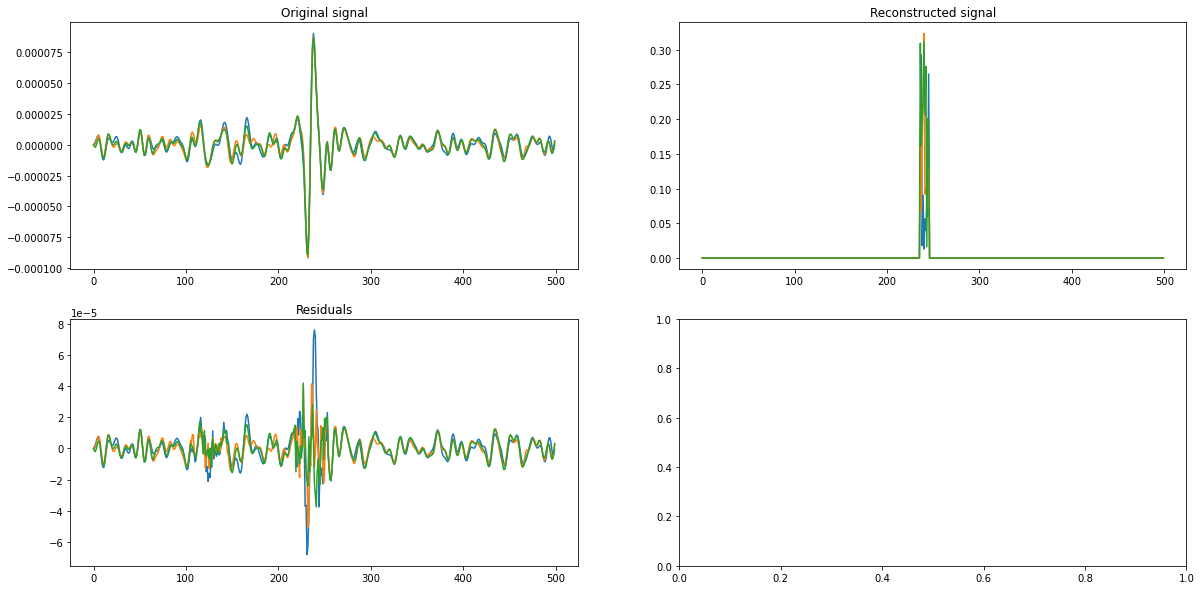

In [17]:
fig, axs = plt.subplots(2,2, figsize = (20,10))
axs[0,0].plot(signal)
axs[0,0].set_title('Original signal')

axs[0,1].plot(recomp)
axs[0,1].set_title('Reconstructed signal')

axs[1,0].plot(residuals)
axs[1,0].set_title('Residuals')